# 基于BERT的情感分类实践

- pytorch
- transformer

##  迁移学习（Transfer Learning）和微调（Fine-tuning）


- BERT 首先在大规模的语料库上进行预训练（Pre-training）
    - 在预训练阶段，BERT 获取了丰富的语言知识，如语法结构、上下文关系等，成为一个 通用的语言表示模型
- BERT 可以被微调（Fine-tuning）以适应具体的下游任务
    - BERT 模型会根据特定任务的标签数据进行进一步训练
    - 模型能够将 预训练获得的通用知识转移到特定任务上，并根据任务的特点进行调整

![](./fine-tuning_methods.png)

In [1]:
import warnings
warnings.filterwarnings("ignore")

## センチメント分析の実装

微调（Fine-tuning）涉及了大量的矩阵运算

- CPU的运算效率普遍较低
- GPU更加适合矩阵运算
- PyTorch对不同类型 GPU 提供了支持
    - 针对NVIDIA GPU 架构的优化

In [2]:
!nvidia-smi

Thu Apr 10 23:10:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0  On |                  Off |
| 35%   54C    P8             35W /  300W |    3993MiB /  49140MiB |      5%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Dataset

#### 从Hugging Face获取示例数据

Hugging Face 提供了各种各样的数据集。这里我们将以一个多语言的情感分析数据集为例进行使用。该数据集包含英文和中文的子集。


In [3]:
#!pip install datasets

In [4]:
from datasets import load_dataset
#dataset = load_dataset("tyqiangz/multilingual-sentiments", "chinese")
dataset = load_dataset("tyqiangz/multilingual-sentiments", "english")

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 870
    })
})

#### 数据确认

我们来确认一下获取到的数据集的内容。

该数据集被划分为 train（训练集）、validation（验证集）和 test（测试集）三部分，
并且包含了诸如 'text'（文本）、'source'（来源）、'label'（标签）等信息。


In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 1839
    })
    validation: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 324
    })
    test: Dataset({
        features: ['text', 'source', 'label'],
        num_rows: 870
    })
})

In [7]:
dataset.set_format(type="pandas")
train_df = dataset["train"][:]
train_df.head(5)

,text,source,label
0,okay i\u2019m sorry but TAYLOR SWIFT LOOKS NOT...,sem_eval_2017,2
1,@user the DC comics site has Batman 44 release...,sem_eval_2017,1
2,"""Frank Gaffrey\u002c Cliff May\u002c Steve Eme...",sem_eval_2017,0
3,The tragedy of only thinking up hilarious twee...,sem_eval_2017,2
4,"""Oliseh meets with Victor Moses in London: Sup...",sem_eval_2017,1


In [8]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'source': Value(dtype='string', id=None),
 'label': ClassLabel(names=['positive', 'neutral', 'negative'], id=None)}

<Axes: title={'center': 'Train Dataset'}, ylabel='label'>

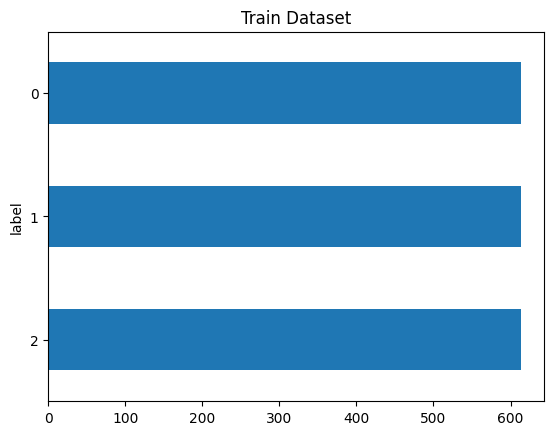

In [9]:
import matplotlib.pyplot as plt
train_df["label"].value_counts(ascending=True).plot(kind="barh", title="Train Dataset")

#### 文本内容的确认

Transformer模型有一个称为maximum context size的最大输入序列长度。

- 模型的计算复杂度会随着输入序列的长度的增加而增加,需要进行适当的调整以适应硬件限制

如果文本超过了模型的上下文大小，就需要将其截断。如果截断的部分包含重要信息，可能会导致性能下降。

In [10]:
train_df["text_length"]=train_df["text"].str.len()

<Axes: title={'center': 'text_length'}, xlabel='label'>

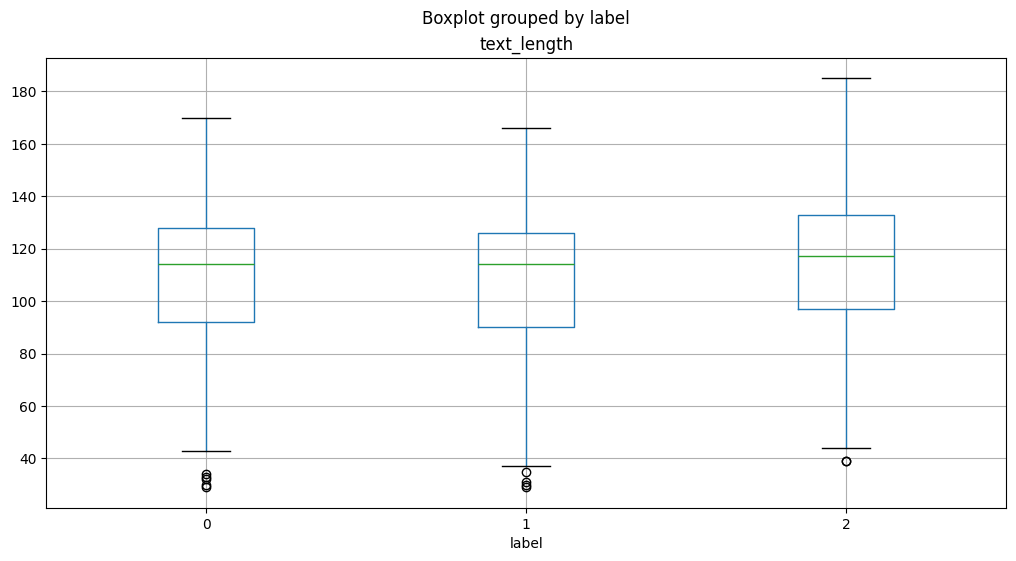

In [11]:
train_df.boxplot(column="text_length", by="label", figsize=(12, 6))


### Tokenization

计算机无法直接接收原始字符串作为输入。因此，需要先对文本进行分词（tokenization），将其编码成数值向量后才能使用。

Tokenization是指将字符串分解成模型能够处理的最小单位的过程。

Transformer库提供了便捷的AutoTokenizer类，可以快速调用与预训练模型相对应的分词器（Tokenizer）。

#### tokenizer的使用


分词器（Tokenizer）将文本转换为数值形式：

- 将输入文本拆分成多个Token（标记）。

- 自动添加特殊的Token（如句首、句尾标记等）。

- 将Token转换成对应的Token ID（数字标识）。

In [12]:
from transformers import AutoTokenizer
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [13]:
train_df["text"][0]

'okay i\\u2019m sorry but TAYLOR SWIFT LOOKS NOTHING LIKE JACKIE O SO STOP COMPARING THE TWO. c\\u2019mon America aren\\u2019t you sick of her yet? (sorry) '

In [14]:
sample_text_encoded = tokenizer(train_df["text"][0])
sample_text_encoded

{'input_ids': [101, 3100, 1045, 1032, 23343, 24096, 2683, 2213, 3374, 2021, 4202, 9170, 3504, 2498, 2066, 9901, 1051, 2061, 2644, 13599, 1996, 2048, 1012, 1039, 1032, 23343, 24096, 2683, 8202, 2637, 4995, 1032, 23343, 24096, 2683, 2102, 2017, 5305, 1997, 2014, 2664, 1029, 1006, 3374, 1007, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

结果中包含input_ids和attention_mask：

- input_ids：表示经过数值编码后的Token标）。

- attention_mask：用于指示模型应关注（有效）或忽略（无效）的Token掩码。对于无效的Token（例如补齐用的PAD Token），attention_mask的值通常设为0。

在每个batch中，输入序列会根据batch内的最长序列长度进行补齐（padding）。
- 模型训练或推理时，通常不会逐条数据单独输入，而是将多条数据整合成一个组（即batch），同时送入模型

 ![](./attention_id.png)


分词器（Tokenizer）的结果是以数字形式编码的，因此若要获取对应的标记字符串（Token），可使用convert_ids_to_tokens方法。

- 句子的开头和结尾分别以特殊标记[CLS]（句首标记）和[SEP]（句尾标记）表示。
    - 在预训练的过程中用特殊标记帮助模型更好地理解文本输入的结构和语义信息
    - 基本上由模型设计者根据模型的预训练任务和模型架构的具体要求和标准化的惯例进行定义

In [15]:
tokens = tokenizer.convert_ids_to_tokens(sample_text_encoded.input_ids)
print(tokens)

['[CLS]', 'okay', 'i', '\\', 'u2', '##01', '##9', '##m', 'sorry', 'but', 'taylor', 'swift', 'looks', 'nothing', 'like', 'jackie', 'o', 'so', 'stop', 'comparing', 'the', 'two', '.', 'c', '\\', 'u2', '##01', '##9', '##mon', 'america', 'aren', '\\', 'u2', '##01', '##9', '##t', 'you', 'sick', 'of', 'her', 'yet', '?', '(', 'sorry', ')', '[SEP]']


#### 对于全体数据的处理



In [16]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [17]:
dataset.reset_format()

In [18]:
dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)

In [19]:
import pandas as pd
sample_encoded = dataset_encoded["train"][0]
pd.DataFrame(
    [sample_encoded["input_ids"]
     , sample_encoded["attention_mask"]
     , tokenizer.convert_ids_to_tokens(sample_encoded["input_ids"])],
    ['input_ids', 'attention_mask', "tokens"]
).T

,input_ids,attention_mask,tokens
0,101,1,[CLS]
1,3100,1,okay
2,1045,1,i
3,1032,1,\
4,23343,1,u2
...,...,...,...
73,0,0,[PAD]
74,0,0,[PAD]
75,0,0,[PAD]
76,0,0,[PAD]


### 分类模型
#### 预训练模型

Transformer库提供了用于调用预训练模型的AutoModel。

AutoModel将Token编码转换为嵌入向量（embeddings），并通过编码器堆叠（Encoder Stack）后，返回最后一层的隐藏状态（hidden states）。


In [20]:
import torch
from transformers import AutoModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

首先，需要对字符串进行编码（encode），将文本转换为PyTorch张量（tensor）形式的Token。

转换后得到的张量形状为```[batch_size,n_tokens]```。

In [21]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


将生成的张量作为模型的输入进行传递：

- 将张量放置到与模型相同的设备（GPU或CPU）上。

- 使用torch.no_grad()禁用梯度的自动计算，以减少计算所需的内存消耗。

- 模型的输出结果包括hidden states、loss以及attention等对象。
    - hidden states是结果模型处理后输出的语义表示(contextualized embeddings)

In [22]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


查看隐藏状态张量，我们可以看到它的形状为：[batch_size, n_tokens, hidden_dim]。

这意味着，对于输入的6个Token（标记），每个Token都会对应生成一个维度为768的向量表示。


In [23]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

在分类任务中，通常的方法是使用```[CLS]``` 标记相关的隐藏状态作为输入特征。
- ```[CLS]``` 通常具备“融合所有 token 的语义信息”的功能

由于该标记出现在每个序列的开头，因此可以通过如下方式，从 outputs.last_hidden_state 中简单地通过索引提取出来：

In [24]:
outputs.last_hidden_state[:,0].size()


torch.Size([1, 768])

我们已经掌握了如何提取最后的隐藏状态，为了对整个数据集进行处理，我们可以将前面的步骤封装成一个函数。

这样就能方便地对所有文本应用模型，并提取出每条文本对应的隐藏状态向量。

In [25]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [26]:
dataset_encoded.set_format(type="torch", columns=["input_ids", "attention_mask","label"])


In [27]:
dataset_hidden=dataset_encoded.map(extract_hidden_states, batched=True, batch_size=32)

#### 分类模型的训练

预处理后的数据集包含了训练分类器所需的所有信息。

具体来说，将隐藏状态作为输入特征，将标签作为目标变量，就可以应用于各种分类算法。

这里我们将训练一个逻辑回归模型,了解一下在没有经过微调的情况下,基于预训练模型的分类模型的表现。

In [28]:
import numpy as np

X_train = np.array(dataset_hidden["train"]["hidden_state"])
X_valid = np.array(dataset_hidden["validation"]["hidden_state"])
y_train = np.array(dataset_hidden["train"]["label"])
y_valid = np.array(dataset_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((1839, 768), (324, 768))

In [29]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [30]:
lr_clf.score(X_valid, y_valid)

0.5987654320987654

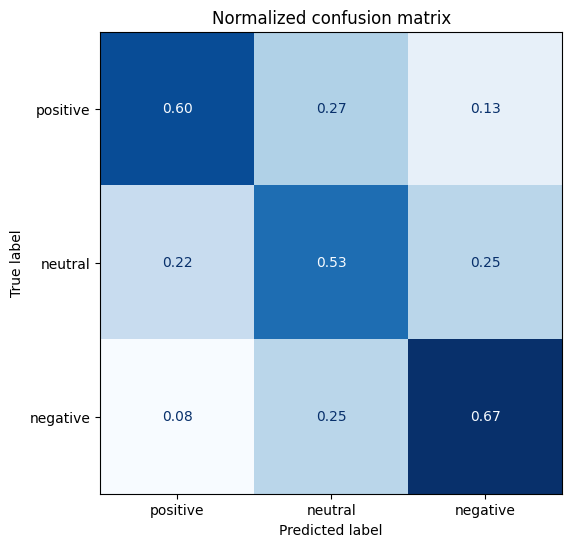

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, ["positive","neutral","negative"])

#### AutoModelForSequenceClassificationのファインチューニング


Transformer库根据不同的微调任务，提供了相应的API。


对于分类任务可以使用```AutoModelForSequenceClassification```。

```AutoModelForSequenceClassification```在预训练模型的输出之上添加了一个classifier head，因此可以更方便地进行模型设置和训练。
- 具体来说, classifier head是在预训练模型的输出层上方添加的一个神经网络层(全连接层,通常加上 softmax)

In [32]:
from transformers import AutoModelForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 3

model = (AutoModelForSequenceClassification
    .from_pretrained(model_ckpt, num_labels=num_labels)
    .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [34]:
inputs = tokenizer("I purchased these boots to use both for everyday wear and when riding my motorcycle.", return_tensors="pt") # pytorch tensorに変換するためにreturn_tensors="pt"を指定
inputs = {k: v.to(device) for k, v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

SequenceClassifierOutput(loss=None, logits=tensor([[0.0874, 0.1617, 0.0631]], device='cuda:0'), hidden_states=None, attentions=None)


#### 训练设置的准备

对于训练的评价指标进行定义




In [35]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

为了提高训练的效率，可以使用 Transformer 库中的```Trainer``` 。

在初始化```Trainer```类时，可以通过传入一个名为```TrainingArguments```的参数，该参数包含了与训练相关的各种设置，从而可以对训练过程进行细致的调整。

In [36]:

from transformers import TrainingArguments

batch_size = 32
logging_steps = len(dataset_encoded["train"]) // batch_size

training_args = TrainingArguments(
    output_dir="./logs",
    num_train_epochs=15,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=False,
    log_level="error",
    report_to="none" 
)

使用Trainer类来执行模型训练。

从结果来看，可以微调预训练模型的方法实现了更为出色的性能。

In [37]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset_encoded["train"],
    eval_dataset=dataset_encoded["validation"],
    tokenizer=tokenizer
)
trainer.train()

2025-04-10 23:11:13.660327: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 23:11:13.666371: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744294273.672982 1198518 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744294273.674923 1198518 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-10 23:11:13.682279: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,1.018939,0.533951,0.503114
2,1.004100,0.818069,0.638889,0.611983
3,1.004100,0.763208,0.657407,0.645520
4,0.682700,0.707329,0.672840,0.676133
5,0.682700,0.731131,0.691358,0.684245
6,0.430900,0.769803,0.672840,0.676004
7,0.430900,0.808148,0.663580,0.666487
8,0.287600,0.877261,0.663580,0.667266
9,0.287600,0.898489,0.663580,0.665158
10,0.175000,0.981142,0.663580,0.669582


TrainOutput(global_step=435, training_loss=0.37003939288786086, metrics={'train_runtime': 48.8043, 'train_samples_per_second': 565.217, 'train_steps_per_second': 8.913, 'total_flos': 556691234203260.0, 'train_loss': 0.37003939288786086, 'epoch': 15.0})

### 使用微调后的模型

#### 检验模型精度

在(训练数据以外的)其它数据上使用微调后的模型进行情感分类


In [38]:
preds_output = trainer.predict(dataset_encoded["test"])

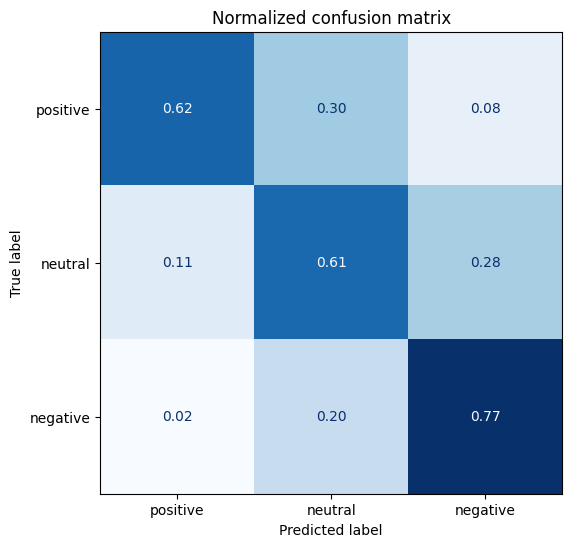

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)
y_valid = np.array(dataset_encoded["test"]["label"])
labels = dataset_encoded["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_valid, labels)

#### モデル保存



In [40]:
id2label = {}
for i in range(dataset["train"].features["label"].num_classes):
    id2label[i] = dataset["train"].features["label"].int2str(i)

label2id = {}
for i in range(dataset["train"].features["label"].num_classes):
    label2id[dataset["train"].features["label"].int2str(i)] = i

trainer.model.config.id2label = id2label
trainer.model.config.label2id = label2id

In [41]:
#trainer.save_model(f"./Data/sample-text-classification-bert")

#### 学習済みモデルの読み込み


In [ ]:
new_tokenizer = AutoTokenizer\
    .from_pretrained(f"./Data/sample-text-classification-bert")

new_model = (AutoModelForSequenceClassification
    .from_pretrained(f"./Data/sample-text-classification-bert")
    .to(device))

In [ ]:
def id2label(x):
    label_dict={0:"positive",1:"neutral",2:"negative"}
    return label_dict[x]

In [ ]:
text1="this week is not going as i had hoped"
text2="awe i love you too!!!! 1 am here i miss you"

In [ ]:

inputs = new_tokenizer(text1, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
outputs.logits

y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
y_preds = [id2label(x) for x in y_preds]
y_preds

['negative']

In [ ]:
inputs = new_tokenizer(text2, return_tensors="pt")

new_model.eval()

with torch.no_grad():
    outputs = new_model(
        inputs["input_ids"].to(device), 
        inputs["attention_mask"].to(device),
    )
outputs.logits

y_preds = np.argmax(outputs.logits.to('cpu').detach().numpy().copy(), axis=1)
y_preds = [id2label(x) for x in y_preds]
y_preds

['positive']